In [194]:
# n gives nth phq answer
# 10 gives sum of all phqs
def Yer(y, n):
    return y[:,n-1:n]


contactsStartEnd = [0,1]
twitterStartEnd = [1,5]
textStartEnd = [5,78]
callStartEnd = [78,92]
instagramStartEnd = [92,110]
audioStartEnd = [110,1693]
allStartEnd = [contactsStartEnd[0], audioStartEnd[1]]


ftypes = ["au","ig","txt","con","tw","call","all"]

# ftype = "au" audio / "ig" instagram / "txt" text / "con" contacts / "tw" twitter / "call" call
# "all" = big matrix
def Xer(X, ftype):
    if(ftype == "au"):
        return X[:,audioStartEnd[0]:audioStartEnd[1]]
    if(ftype == "ig"):
        return X[:,instagramStartEnd[0]:instagramStartEnd[1]]
    if(ftype == "txt"):
        return X[:,textStartEnd[0]:textStartEnd[1]]
    if(ftype == "con"):
        return X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    if(ftype == "tw"):
        return X[:,twitterStartEnd[0]:twitterStartEnd[1]]
    if(ftype == "call"):
        return X[:,callStartEnd[0]:callStartEnd[1]]
    if(ftype == "all"):
        return X[:,allStartEnd[0]:allStartEnd[1]]
    
    
    

## READ FEATURES INTO MEMORY

import pandas as pd
import sklearn
import numpy as np
from sklearn import preprocessing

mtr = pd.read_csv("mtr.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column
#mtr.shape

## PREPROCESSING

import pandas as pd
from sklearn.preprocessing import Imputer

# shuffle row-wise
np.random.shuffle(mtr)

data = mtr[:,0:1693]
labels = mtr[:,1693:1704]

# normalize data (features now have gauss dist., 0 mean and unit variance)
data = sklearn.preprocessing.scale(data)

# THIS IS AN ALTERNATIVE TO 0 MEAN UNIT VARIANCE NORMALIZATION
# do this to scale features to range 0-1
# this must be done if a chi^2 is being performed
# min_max_scaler = preprocessing.MinMaxScaler()
# data = min_max_scaler.fit_transform(data)

# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

# If NaNs should be dropped instead:
# mtr = mtr[~np.isnan(mtr).any(axis=1)]




# DATA SPLIT (#nosnooping)

# TEST DATA (%15 percent of data)
numofppl_index = mtr.shape[0] - 1
cut_index = int(mtr.shape[0] * 0.85)

test_label = labels[cut_index:numofppl_index,:]
test_data = data[cut_index:numofppl_index,:]

# TRAINING AND VALIDATION DATA (%85 percent of data)

train_label = labels[0:cut_index,:]
train_data = data[0:cut_index,:]

In [195]:
def cutoff(train_label):

    phqcutoffs = [10,15,20]

    for j in range(0,len(phqcutoffs)):
        for i in range(0,train_label[:,9:10].shape[0]):
            if(train_label[i][9] > phqcutoffs[j]):
                train_label[i][j] = 1
            else:
                train_label[i][j] = 0
               
    train_label_x = train_label
        
    return train_label_x               

def YerCutOff(y, cutoff):
    if (cutoff == 10):
        return y[:,0:1]
    if (cutoff == 15):
        return y[:,1:2]
    if (cutoff == 20):
        return y[:,2:3]
    
train_label = cutoff(train_label)

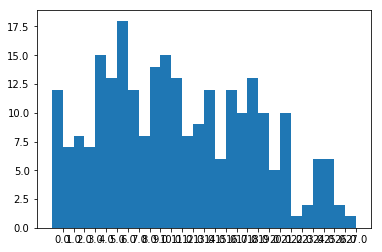

In [196]:
lizz = train_label[:,9:10].tolist()
lizzn = []
for i in range(0,len(lizz)):
    lizzn.append(lizz[i][0])
    
from collections import Counter

Counter(lizzn)


from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


labels, values = zip(*Counter(lizzn).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [142]:

X = Xer(train_data, "all")
y = YerCutOff(train_label, 20).reshape(train_label.shape[0],)

from sklearn.linear_model import RandomizedLasso

rlasso = RandomizedLasso()
rlasso.fit_transform(X, y)

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.156e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=1.078e-03, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)

array([], shape=(255, 0), dtype=float64)

In [162]:
rlasso.scores_[0:500]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.075, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

In [166]:
X.shape

(255, 1693)

In [168]:
Xla = np.zeros((255, 1))

for i in range(0,len(rlasso.scores_)):
    if(rlasso.scores_[i] != 0):
        Xla = np.hstack((Xla, X[:,i:i+1]))

In [156]:
Xla = np.delete(Xla, 0, 1)

In [169]:
Xla.shape

(255, 66)

In [177]:
############################ SVC #############################
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')

X = Xer(train_data, "all")
y = YerCutOff(train_label, 20).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
X = sel.fit_transform(X)

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':list([0.001,0.01,0.1,1,2,3,4,5,6,7,8,10])}


grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xla, y)

grid.best_score_

0.8235294117647058

In [178]:
grid.grid_scores_
# grid.best_score_

[mean: 0.76863, std: 0.01870, params: {'C': 0.001, 'kernel': 'linear'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'rbf'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'poly'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.001, 'kernel': 'sigmoid'},
 mean: 0.75294, std: 0.01864, params: {'C': 0.01, 'kernel': 'linear'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.01, 'kernel': 'rbf'},
 mean: 0.82353, std: 0.07382, params: {'C': 0.01, 'kernel': 'poly'},
 mean: 0.50196, std: 0.39413, params: {'C': 0.01, 'kernel': 'sigmoid'},
 mean: 0.72157, std: 0.01286, params: {'C': 0.1, 'kernel': 'linear'},
 mean: 0.75686, std: 0.03042, params: {'C': 0.1, 'kernel': 'rbf'},
 mean: 0.77255, std: 0.01479, params: {'C': 0.1, 'kernel': 'poly'},
 mean: 0.76863, std: 0.01870, params: {'C': 0.1, 'kernel': 'sigmoid'},
 mean: 0.72941, std: 0.00286, params: {'C': 1, 'kernel': 'linear'},
 mean: 0.75686, std: 0.01473, params: {'C': 1, 'kernel': 'rbf'},
 mean: 0.76863, std: 0.0187

In [174]:
svc = SVC(class_weight='balanced', C=0.1, kernel='rbf')
parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xla, y)


GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [88]:
grid.grid_scores_


[mean: 0.84706, std: 0.05158, params: {}]

In [179]:
from sklearn.metrics import classification_report

predictions = grid.predict(Xla)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

        0.0       0.92      0.82      0.87       228
        1.0       0.20      0.37      0.26        27

avg / total       0.84      0.78      0.80       255



In [114]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(1.05))
Xsel = sel.fit_transform(X)
Xsel.shape

(255, 305)

In [117]:
svc = SVC(class_weight='balanced', C=0.1, kernel='rbf')
parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(Xsel, y)
grid.grid_scores_

[mean: 0.84706, std: 0.05158, params: {}]

In [119]:
from sklearn.metrics import classification_report

predictions = grid.predict(Xsel)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

        0.0       0.92      0.81      0.86       230
        1.0       0.17      0.36      0.23        25

avg / total       0.85      0.77      0.80       255



In [34]:
liznb.index(max(liznb))
max(liznb)

0.0

In [40]:
# X_new = SelectKBest(chi2, k=100).fit_transform(X, y)
# X_new.shape

parameters = {}

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(X, y)

grid.best_score_

0.7058823529411765

             precision    recall  f1-score   support

        0.0       0.71      1.00      0.83       179
        1.0       1.00      0.05      0.10        76

avg / total       0.80      0.72      0.61       255



In [197]:
############################ SVR #############################
from sklearn.grid_search import GridSearchCV

from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(train_label.shape[0],)

svr = SVR()

c_range = [0.001,0.005,0.01,0.1,1,2,3,10]
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}


grid = GridSearchCV(svr, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(Xla, y)

grid.grid_scores_

[mean: -48.36076, std: 4.91629, params: {'C': 0.001, 'kernel': 'linear'},
 mean: -48.48363, std: 5.11873, params: {'C': 0.001, 'kernel': 'rbf'},
 mean: -48.47340, std: 5.10615, params: {'C': 0.001, 'kernel': 'poly'},
 mean: -48.48446, std: 5.11947, params: {'C': 0.001, 'kernel': 'sigmoid'},
 mean: -48.30797, std: 4.56934, params: {'C': 0.005, 'kernel': 'linear'},
 mean: -48.47711, std: 5.11448, params: {'C': 0.005, 'kernel': 'rbf'},
 mean: -48.42917, std: 5.05056, params: {'C': 0.005, 'kernel': 'poly'},
 mean: -48.48173, std: 5.11783, params: {'C': 0.005, 'kernel': 'sigmoid'},
 mean: -48.84453, std: 3.90861, params: {'C': 0.01, 'kernel': 'linear'},
 mean: -48.46927, std: 5.10906, params: {'C': 0.01, 'kernel': 'rbf'},
 mean: -48.36964, std: 4.99038, params: {'C': 0.01, 'kernel': 'poly'},
 mean: -48.47940, std: 5.11517, params: {'C': 0.01, 'kernel': 'sigmoid'},
 mean: -55.87142, std: 2.88155, params: {'C': 0.1, 'kernel': 'linear'},
 mean: -48.33791, std: 5.02517, params: {'C': 0.1, 'kern

In [200]:
grid.best_score_

-48.09352610843258